In [1]:
import datastore

import pandas as pd
import matplotlib.pyplot as plt

spot = datastore.getSpotPrice()

cons_gwh = datastore.getConsumptionGWh()

nuclear_finland_germany_mwh = datastore.getHourlyProduction_nuclear_EU()
germany_all = datastore.getHourlyProduction_Germany_all()

production_se1_mwh = datastore.getAllSE1ProductionMWh() 
production_se2_mwh = datastore.getAllSE2ProductionMWh()
production_se3_mwh = datastore.getAllSE3ProductionMWh()
production_se4_mwh = datastore.getAllSE4ProductionMWh()

hydroReservoirs = datastore.getWeeklyHydroReservs()

temp_pen = datastore.getDailyWeather()

# stationCap = datastore.getStationCap_forecast()
# transTo = datastore.getTransmissionCapTo_forecast()
# transFrom = datastore.getTransmissionCapFrom_forecast()

# productionCap = datastore.getProductionCap_forecast()

Missing values in Index(['spotPrice'], dtype='object') : 6
Missing values in Index(['ConsumptionSE1GWh', 'ConsumptionSE2GWh', 'ConsumptionSE3GWh',
       'ConsumptionSE4GWh'],
      dtype='object') : 60
Missing values in Index(['nucFI(MWh)', 'nucDE(MWh)'], dtype='object') : 944
Missing values in Index(['wind(Mwh)', 'solar(Mwh)', 'trm(Mwh)', 'biomass(Mwh)', 'coal(MWh)',
       'gas(MWh)', 'oil(MWh)', 'lignite(MWh)', 'nuc(MWh)', 'pump(MWh)',
       'other(MWh)', 'waste(MWh)'],
      dtype='object') : 1337
Missing values in Index(['waterSE1(MWh)', 'windSE1(MWh)', 'trmSE1MWh'], dtype='object') : 151
Missing values in Index(['waterSE2(MWh)', 'windSE2(MWh)', 'solSE2MWh', 'trmSE2MWh', 'OthSE2MWh'], dtype='object') : 345
Missing values in Index(['waterSE3(MWh)', 'windSE3(MWh)', 'nucSE3(MWh)', 'solSE3MWh',
       'trmSE3MWh', 'OthSE3MWh'],
      dtype='object') : 388
Missing values in Index(['waterSE4(MWh)', 'windSE4(MWh)', 'solSE4MWh', 'trmSE4MWh', 'OthSE4MWh'], dtype='object') : 356
Missing v

In [40]:
import calendar_features as cf

dataset = pd.concat([spot, cons_gwh, production_se1_mwh, production_se2_mwh, 
                                    production_se3_mwh, production_se4_mwh, temp_pen, hydroReservoirs], axis=1)

daylight_features = cf.daylight_extractor(dataset)
holiday_features = cf.get_holidays(dataset)
calendar_features = cf.calendar_transformer(dataset).get(["year", "month", "day_of_week", "weekend", "hour"])

future_covariates = pd.concat([daylight_features, holiday_features, calendar_features], axis=1)

dataset.interpolate(method = 'linear', limit_direction = 'forward', inplace=True, axis=0)

# dataset = cf.calendar_transformer(dataset)

# dataset = pd.concat([dataset, daylight_features, holiday_features], axis=1)

In [41]:
from darts import TimeSeries, concatenate
from darts.dataprocessing.transformers import Scaler

# Split applies on the whole dataset
train_split = int(len(dataset) * 0.7)
validation_split = int(len(dataset) * 0.85)
test_split = len(dataset)

features = dataset.drop('spotPrice', axis=1)
target = dataset['spotPrice']
 
past_covariates = TimeSeries.from_dataframe(features ,freq='h')
future_covariates = TimeSeries.from_dataframe(future_covariates, freq='h')
target = TimeSeries.from_series(target, freq='h')

past_scaler, target_scaler, future_scaler = Scaler(), Scaler(), Scaler()

past_covariates_scaled = target_scaler.fit_transform(past_covariates)
future_covariates_scaled = future_scaler.fit_transform(future_covariates)
target_scaled = past_scaler.fit_transform(target)


past_covariates_train, past_covariates_val, past_covariates_test = past_covariates_scaled[:train_split], past_covariates_scaled[train_split:validation_split], past_covariates_scaled[validation_split:test_split]
target_train, target_val, target_test = target_scaled[:train_split], target_scaled[train_split:validation_split], target_scaled[validation_split:test_split]
future_covirates_train, future_covirates_val, future_covirates_test = future_covariates_scaled[:train_split], future_covariates_scaled[train_split:validation_split], future_covariates_scaled[validation_split:test_split]


past_covariates, target, future_covirates = concatenate([past_covariates_train, past_covariates_val]), concatenate([target_train, target_val]), concatenate([future_covirates_train, future_covirates_val])

In [43]:
from darts.models import BlockRNNModel
from darts.utils.callbacks import TFMProgressBar


model = BlockRNNModel(
    model='LSTM',
    input_chunk_length=24,
    output_chunk_length=12,
    random_state=0,
    n_epochs=35, 
    hidden_dim=25
)

model.fit(
    series = [target_train], 
    val_series = [target_val],
    past_covariates = [past_covariates],
    val_past_covariates = [past_covariates], 
    
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3070') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 5.5 K 
4 | fc            | Sequential       | 312   
---------------------------------------------------
5.8 K     Trainable params
0         Non-trainable params
5.8

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=35` reached.


BlockRNNModel(model=LSTM, hidden_dim=25, n_rnn_layers=1, hidden_fc_sizes=None, dropout=0.0, input_chunk_length=24, output_chunk_length=12, random_state=0, n_epochs=35)

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

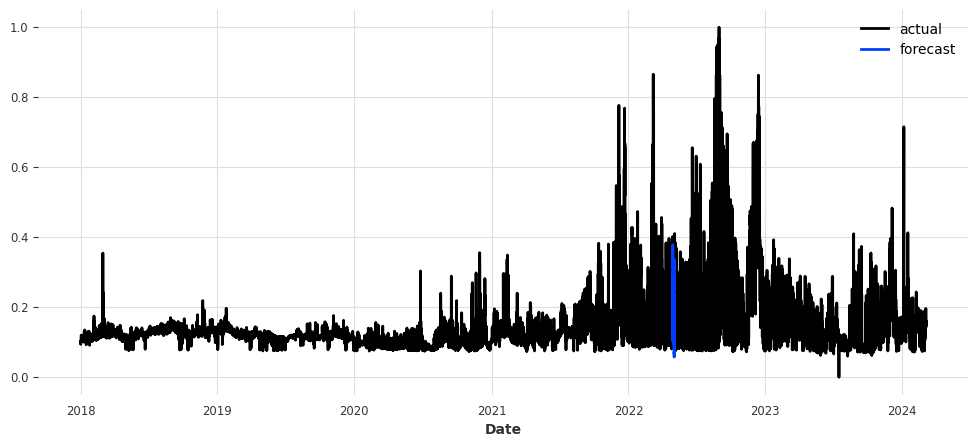

In [69]:
pred = model.predict(n = 124, series=target_train, past_covariates=past_covariates)

plt.figure(figsize=(12,5))
target_scaled.plot(label='actual')

pred.plot(label='forecast')

plt.legend()


In [73]:
backtest = model.historical_forecasts(
    series = target_scaled, 
    past_covariates = past_covariates, 
    start = target_val.start_time(),
    forecast_horizon = 12,
    stride = 12,
    last_points_only = False,
    retrain = False,
    verbose = True
    )
backtest = concatenate(backtest)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [75]:
from darts.metrics import mape, mae

mae = mae(target_scaled, backtest)
mape = mape(target_scaled, backtest)

print(f"MAE: {mae}")
print(f"MAPE: {mape}")

plt.figure(figsize=(12,5))
target_scaled.plot(label='actual')
backtest.plot(label='forecast')

MAE: 0.05900932335573303
MAPE: 28.640295509584412
